# Applied Data Science Capstone - The Battle of Neighborhoods
## Where to Open a New East Asian Restaurant in Toronto

This notebook completes the capstone project of the Coursera course - Applied Data Science Capstone. The topic is **the battle of neighborhoods**.

First of all, let us import the libraries that will be useful.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
#!conda install -c conda-forge folium --yes
import folium # map rendering library

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Canada is an immigrant country. As a result, there is a large number of immigrants in the metropolises of Canada who originate from different foreign countries. Toronto is one of the examples, in which about 46 percent of population are immigrants, according to the public data source. The immigrants will also bring unique traditions, cultures besides help developing the economy of the country. Food is one of the diversities that will definitely be taken in. Hence, there is a variety of local restaurants offer special food that originate from other different countries. For example, you can come across Japanese restaurants in Toronto.
As immigrant population continues to grow, new restaurants are also opening. Under such circumstances, we are interested in searching for a good region of the Toronto city to launch a new East Asian restaurant. The three main countries in East Asian are China, Korean and Japanese. This report will be specifically useful for the stakeholders who are interested to open a new East Asian restaurant in Toronto.

## Data <a name="data"></a>

We need the neighbor information of Toronto.
We can load the table into dataframe from the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. 

And we need to clean the data into a well-structured neighbourhood datafame:
1. Make the "Not assigned" in the table to be converted to NaN in the dataframe.
2. Drop the NaN values and reset the index

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url, match = 'Postal Code', na_values = ['Not assigned'])
df = dfs[0]
df.dropna(axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)
df

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
We will load the geographical coordinates of each postal code from the csv file via: http://cocl.us/Geospatial_data

In [3]:
csv = 'http://cocl.us/Geospatial_data'
df_coor = pd.read_csv(csv)
df_coor

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


Then merge the coordinate dataframe with the neighborhood dataframe. To be consistent, we change the column name "Neighbourhood" to "Neighborhood". And we can find that there are 103 different regions according to the postal codes although a few of them have same neighborhood names but different coordinates.

In [4]:
df_toronto_neighborhood = df.merge(df_coor)
df_toronto_neighborhood.rename(columns = {"Neighbourhood": "Neighborhood"}, inplace = True)
print(df_toronto_neighborhood.nunique())
df_toronto_neighborhood

Postal Code     103
Borough          10
Neighborhood     99
Latitude        103
Longitude        75
dtype: int64


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


With the `df_toronto_neighborhood` storing the neighborhood information of Toronto, we will couple it with the Foursquare location data to analyze the distribution of the East Asian restaurants in Toronto. 

## Methodology <a name="methodology"></a>

From the processed neighborhood data of Toronta, we know there are 10 boroughs and 103 different regions. Firstly, we use k-means to divide the 103 regions to 10 groups according to their coordinates.

In [5]:
kclusters = 10

kmeans_toronto = df_toronto_neighborhood[['Latitude', 'Longitude']]

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=15).fit(kmeans_toronto)

kmeans.labels_

array([6, 7, 4, 3, 4, 1, 9, 7, 7, 4, 3, 1, 9, 7, 7, 4, 0, 1, 9, 7, 4, 3,
       9, 0, 4, 4, 9, 8, 8, 7, 4, 3, 2, 6, 5, 7, 4, 4, 2, 8, 3, 7, 4, 4,
       2, 8, 5, 7, 4, 3, 5, 2, 8, 5, 7, 0, 3, 5, 2, 8, 5, 0, 0, 3, 5, 2,
       8, 0, 0, 3, 5, 6, 8, 0, 4, 3, 1, 5, 6, 0, 4, 3, 6, 0, 4, 6, 0, 4,
       1, 5, 6, 4, 4, 1, 5, 9, 4, 4, 1, 4, 7, 1, 1])

Add the classified group labels to `df_toronto_neighborhood`

In [6]:
df_toronto_neighborhood['Group'] = pd.Series(kmeans.labels_)
df_toronto_neighborhood

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Group
0,M3A,North York,Parkwoods,43.753259,-79.329656,6
1,M4A,North York,Victoria Village,43.725882,-79.315572,7
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,4
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,7
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,1


And we can get the coordinates of the centroid of each group and transfer them into a dataframe `df_toronto_groups`

In [7]:
toronto_groups = kmeans.cluster_centers_

# Transfer the group centroids into the form of dataframe
df_toronto_groups = pd.DataFrame(toronto_groups)
df_toronto_groups.rename(columns={0: 'Latitude', 1: 'Longitude'}, inplace = True)
df_toronto_groups['Group'] = [i for i in range(10)]
df_toronto_groups 

,Latitude,Longitude,Group
0,43.707385,-79.399664,0
1,43.636232,-79.539027,1
2,43.725026,-79.260618,2
3,43.687618,-79.466296,3
4,43.654310,-79.388595,4
5,43.728769,-79.536069,5
6,43.781780,-79.305908,6
7,43.694777,-79.328980,7
8,43.774649,-79.403212,8
9,43.789174,-79.200932,9


Next, we visualize the 103 regions and 10 groups on the map of Toronto. The 10 large dots represent the centroids of each group while the small dots are the coordinates of the 103 regions. Each of the large circles cover a radius of 4000 meters around the centroids. We can see that the 10 large circles cover most part of Toronto City.

In [8]:
# create map
Toronto_location = [43.6532, -79.3832]
map_clusters = folium.Map(location=Toronto_location, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add regions to the map
for lat, lon, poi, cluster in zip(df_toronto_neighborhood['Latitude'], df_toronto_neighborhood['Longitude'], df_toronto_neighborhood['Neighborhood'], df_toronto_neighborhood['Group']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=False
        ).add_to(map_clusters)

# add centroids to the map
for i in range(len(toronto_groups)):
    label = folium.Popup('Group ' + str(i), parse_html = True)
    folium.CircleMarker(
        [toronto_groups[i][0], toronto_groups[i][1]],
        radius=5,
        popup = label,
        color=rainbow[i-1],
        fill=True,
        fill_color=rainbow[i-1],
        fill_opacity=1
        ).add_to(map_clusters)

# add large circles to the map
    label = 'Group '+str(i)
    folium.Circle([toronto_groups[i][0], toronto_groups[i][1]],radius=4000,popup = 'a',color=rainbow[i-1],fill=False).add_to(map_clusters)
    
    
map_clusters

We would like to know the number of East Asian restaurants in each circle. Hence, we will utilize Foursquare API. We will define some variables and functions at first.

In [9]:
CLIENT_ID = 'RJGE14XT4KBYBSI1JJ4UGN31Y1M1KUOXTWDRW4JOVLPZ5IBX' # your Foursquare ID
CLIENT_SECRET = '1W2OJCV4AWNRJHEQRWFPVM3AN2HZ3EDY1BBHMRCRPIR2IC0A' # your Foursquare Secret

In [10]:
VERSION = '20200801' # Foursquare API version
food_category = {'Japanese':'4bf58dd8d48988d111941735', 'Korean': '4bf58dd8d48988d113941735', 'Chinese': '4bf58dd8d48988d145941735'}
radius = 4000
LIMIT = 50

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function that search the nearby chosen category of venues
def search_nearby(latitude, longitude, search_query = 'restaurant', radius = 100, LIMIT = 30):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = pd.json_normalize(venues)
    
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    return dataframe_filtered

# function that explore the nearby chosen category of venuse
def explore_nearby(latitude, longitude, food_category = '4bf58dd8d48988d113941735', radius = 100, LIMIT = 50):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, food_category, radius, LIMIT)
    
    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['groups'][0]['items']

    # tranform venues into a dataframe
    dataframe = pd.json_normalize(venues)
    
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
#    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
#    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
#    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    try:
        dataframe_filtered = dataframe.loc[:, filtered_columns]

        # filter the category for each row
        dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    except:
        dataframe_filtered = pd.DataFrame()
    
    return dataframe_filtered

In [12]:
def restaurant_map(dfs_restaurant):
    map_clusters = folium.Map(location=Toronto_location, zoom_start=11)

    # add markers to the map  
    for i in range(len(toronto_groups)):
        label = folium.Popup('Group ' + str(i), parse_html = True)
        folium.CircleMarker(
            [toronto_groups[i][0], toronto_groups[i][1]],
            radius=5,
            popup = label,
            color=rainbow[i-1],
            fill=False
            ).add_to(map_clusters)
    
        label = 'Group '+str(i)
        folium.Circle([toronto_groups[i][0], toronto_groups[i][1]],radius=4000,popup = label,color=rainbow[i-1],fill=False).add_to(map_clusters)

    for i in range(len(dfs_restaurant)):
        if len(dfs_restaurant[i]) > 0:
            for lat, lon in zip(dfs_restaurant[i]['lat'], dfs_restaurant[i]['lng']):
                folium.CircleMarker([lat, lon], radius=3, color=rainbow[i-1], fill=True, fill_color=rainbow[i-1], fill_opacity=1).add_to(map_clusters)

    return map_clusters

Then we will explore the number of Chinese, Japanese and Korean restaurants in the 10 circles covering the city of Toronto, respectively, using Foursquare API and the functions defined above.

## Results <a name="results"></a>

Firstly, we will explore the Korean restaurants.

In [14]:
country = 'Korean'
dfs_korean_restaurant = []

for i in range(len(df_toronto_groups['Group'])):
    df = explore_nearby(df_toronto_groups['Latitude'][i], df_toronto_groups['Longitude'][i], food_category[country], radius, LIMIT)
    print('Group ' + str(i) + ' has ' + str(len(df)) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')
    dfs_korean_restaurant.append(df)

dfs_korean_restaurant[1]

Group 0 has 3 Korean restaurants within 4000 meters radius of the centroid.
Group 1 has 6 Korean restaurants within 4000 meters radius of the centroid.
Group 2 has 2 Korean restaurants within 4000 meters radius of the centroid.
Group 3 has 5 Korean restaurants within 4000 meters radius of the centroid.
Group 4 has 50 Korean restaurants within 4000 meters radius of the centroid.
Group 5 has 2 Korean restaurants within 4000 meters radius of the centroid.
Group 6 has 13 Korean restaurants within 4000 meters radius of the centroid.
Group 7 has 2 Korean restaurants within 4000 meters radius of the centroid.
Group 8 has 50 Korean restaurants within 4000 meters radius of the centroid.
Group 9 has 1 Korean restaurants within 4000 meters radius of the centroid.


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,Chaban,Korean Restaurant,872 The Queensway,Chartwell Road,43.624817,-79.510430,"[{'label': 'display', 'lat': 43.624817, 'lng':...",2631,M8Z 1N7,CA,Stonegate - Queensway,Toronto,ON,Canada,"[872 The Queensway (Chartwell Road), Toronto O...",5658f060498e3d9d3839e3b7
1,Chodang Soon Tofu,Korean Restaurant,5130A Dundas Street West,NaN,43.644062,-79.533144,"[{'label': 'display', 'lat': 43.64406178847928...",992,M9A 1C2,CA,NaN,Etobicoke,ON,Canada,"[5130A Dundas Street West, Etobicoke ON M9A 1C...",4b47e0b5f964a520914226e3
2,Kisoya Sushi,Korean Restaurant,5084 Dundas St. W,NaN,43.645074,-79.532124,"[{'label': 'display', 'lat': 43.64507430815286...",1130,NaN,CA,NaN,Etobicoke,ON,Canada,"[5084 Dundas St. W, Etobicoke ON, Canada]",4b943097f964a520ae6d34e3
3,I Love Sushi,Sushi Restaurant,4944 Dundas St. W.,at Cordova Ave.,43.648393,-79.529215,"[{'label': 'display', 'lat': 43.64839291560182...",1567,M9A 1B7,CA,NaN,Etobicoke,ON,Canada,"[4944 Dundas St. W. (at Cordova Ave.), Etobico...",4e84fce77ee6763749952413
4,Insadong,Korean Restaurant,4941 Dundas Street West,NaN,43.648327,-79.528830,"[{'label': 'display', 'lat': 43.648327, 'lng':...",1577,M9A 1B6,CA,NaN,Etobicoke,ON,Canada,"[4941 Dundas Street West, Etobicoke ON M9A 1B6...",572d4995498e796bd3851d48
5,Koryo Korean BBQ,Korean Restaurant,25 The West Mall,at Sherway Gardens,43.611381,-79.556983,"[{'label': 'display', 'lat': 43.61138112973619...",3121,M9C 1B8,CA,NaN,Toronto,ON,Canada,"[25 The West Mall (at Sherway Gardens), Toront...",4b76e12df964a520a7662ee3


We can see that some of the returned results are not categorized exactly to be Korean Restaurant. So we will clean the results.

In [16]:
for i in range(len(dfs_korean_restaurant)):
    try:
        dfs_korean_restaurant[i] = dfs_korean_restaurant[i][dfs_korean_restaurant[i]['categories'] == country+' Restaurant']
    except:
        pass
    print('Group ' + str(i) + ' has ' + str(len(dfs_korean_restaurant[i])) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')

Group 0 has 1 Korean restaurants within 4000 meters radius of the centroid.
Group 1 has 5 Korean restaurants within 4000 meters radius of the centroid.
Group 2 has 2 Korean restaurants within 4000 meters radius of the centroid.
Group 3 has 3 Korean restaurants within 4000 meters radius of the centroid.
Group 4 has 42 Korean restaurants within 4000 meters radius of the centroid.
Group 5 has 2 Korean restaurants within 4000 meters radius of the centroid.
Group 6 has 12 Korean restaurants within 4000 meters radius of the centroid.
Group 7 has 1 Korean restaurants within 4000 meters radius of the centroid.
Group 8 has 44 Korean restaurants within 4000 meters radius of the centroid.
Group 9 has 1 Korean restaurants within 4000 meters radius of the centroid.


Next we will visualize the results on the map.

In [17]:
korean_restaurant_map = restaurant_map(dfs_korean_restaurant)
korean_restaurant_map

We can observe that the Korean restaurants are mostly found in Group 4 and 8 while the each of the other circles have no more than 5 Korean restaurants except Group 6.

Next, let us explore the Japanese restaurants in Toronto.

In [18]:
country = 'Japanese'
dfs_japanese_restaurant = []

for i in range(len(df_toronto_groups['Group'])):
    df = explore_nearby(df_toronto_groups['Latitude'][i], df_toronto_groups['Longitude'][i], food_category[country], radius, LIMIT)
    print('Group ' + str(i) + ' has ' + str(len(df)) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')
    dfs_japanese_restaurant.append(df)

print('\nClean the search results:')
for i in range(len(dfs_japanese_restaurant)):
    try:
        dfs_japanese_restaurant[i] = dfs_japanese_restaurant[i][dfs_japanese_restaurant[i]['categories'] == country+' Restaurant']
    except:
        pass
    print('Group ' + str(i) + ' has ' + str(len(dfs_japanese_restaurant[i])) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')

japanese_restaurant_map = restaurant_map(dfs_japanese_restaurant)
japanese_restaurant_map

Group 0 has 50 Japanese restaurants within 4000 meters radius of the centroid.
Group 1 has 21 Japanese restaurants within 4000 meters radius of the centroid.
Group 2 has 4 Japanese restaurants within 4000 meters radius of the centroid.
Group 3 has 22 Japanese restaurants within 4000 meters radius of the centroid.
Group 4 has 50 Japanese restaurants within 4000 meters radius of the centroid.
Group 5 has 3 Japanese restaurants within 4000 meters radius of the centroid.
Group 6 has 28 Japanese restaurants within 4000 meters radius of the centroid.
Group 7 has 33 Japanese restaurants within 4000 meters radius of the centroid.
Group 8 has 50 Japanese restaurants within 4000 meters radius of the centroid.
Group 9 has 2 Japanese restaurants within 4000 meters radius of the centroid.

Clean the search results:
Group 0 has 22 Japanese restaurants within 4000 meters radius of the centroid.
Group 1 has 10 Japanese restaurants within 4000 meters radius of the centroid.
Group 2 has 3 Japanese resta

Japanese restaurants are more widely distributed in Toronto than Korean restaurants. 

Finally, we will search for Chinese restaurants in Toronto.

In [19]:
country = 'Chinese'
dfs_chinese_restaurant = []

for i in range(len(df_toronto_groups['Group'])):
    df = explore_nearby(df_toronto_groups['Latitude'][i], df_toronto_groups['Longitude'][i], food_category[country], radius, LIMIT)
    print('Group ' + str(i) + ' has ' + str(len(df)) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')
    dfs_chinese_restaurant.append(df)

print('\nClean the search results:')
for i in range(len(dfs_chinese_restaurant)):
    try:
        dfs_chinese_restaurant[i] = dfs_chinese_restaurant[i][dfs_chinese_restaurant[i]['categories'] == country+' Restaurant']
    except:
        pass
    print('Group ' + str(i) + ' has ' + str(len(dfs_chinese_restaurant[i])) + ' ' + country + ' restaurants within ' + str(radius) + ' meters radius of the centroid.')

chinese_restaurant_map = restaurant_map(dfs_chinese_restaurant)
chinese_restaurant_map

Group 0 has 13 Chinese restaurants within 4000 meters radius of the centroid.
Group 1 has 11 Chinese restaurants within 4000 meters radius of the centroid.
Group 2 has 19 Chinese restaurants within 4000 meters radius of the centroid.
Group 3 has 12 Chinese restaurants within 4000 meters radius of the centroid.
Group 4 has 50 Chinese restaurants within 4000 meters radius of the centroid.
Group 5 has 3 Chinese restaurants within 4000 meters radius of the centroid.
Group 6 has 50 Chinese restaurants within 4000 meters radius of the centroid.
Group 7 has 26 Chinese restaurants within 4000 meters radius of the centroid.
Group 8 has 31 Chinese restaurants within 4000 meters radius of the centroid.
Group 9 has 12 Chinese restaurants within 4000 meters radius of the centroid.

Clean the search results:
Group 0 has 10 Chinese restaurants within 4000 meters radius of the centroid.
Group 1 has 9 Chinese restaurants within 4000 meters radius of the centroid.
Group 2 has 17 Chinese restaurants with

So Chinese restaurants are distributed uniformly in Toronto compared to Korean and Japanese restaurants.

## Discussion <a name="discussion"></a>

We have visually explored the distributions of Chinese, Japanese and Korean restaurants respectively in the 10 groups of neighborhoods. Let's add the data into the `df_toronto_groups`. Also, we add a column **"East Asian Restaurant"** including the total number of Chinese, Japanese and Korean restaurants in each group.

In [29]:
restaurant_dic = {'Chinese': [], 'Japanese': [], 'Korean': []}
for i in range(len(df_toronto_groups)):
    restaurant_dic['Chinese'].append(len(dfs_chinese_restaurant[i]))
    restaurant_dic['Japanese'].append(len(dfs_japanese_restaurant[i]))
    restaurant_dic['Korean'].append(len(dfs_korean_restaurant[i]))

df_toronto_groups['Chinese Restaurant'] = restaurant_dic['Chinese']
df_toronto_groups['Japanese Restaurant'] = restaurant_dic['Japanese']
df_toronto_groups['Korean Restaurant'] = restaurant_dic['Korean']
df_toronto_groups['East Asian Restaurant'] = df_toronto_groups[['Chinese Restaurant', 'Japanese Restaurant', 'Korean Restaurant']].sum(axis = 1)
df_toronto_groups

,Latitude,Longitude,Group,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,East Asian Restaurant
0,43.707385,-79.399664,0,10,22,1,33
1,43.636232,-79.539027,1,9,10,5,24
2,43.725026,-79.260618,2,17,3,2,22
3,43.687618,-79.466296,3,11,6,3,20
4,43.654310,-79.388595,4,47,42,42,131
5,43.728769,-79.536069,5,1,2,2,5
6,43.781780,-79.305908,6,47,22,12,81
7,43.694777,-79.328980,7,21,11,1,33
8,43.774649,-79.403212,8,25,32,44,101
9,43.789174,-79.200932,9,11,0,1,12


Next, let us visulize the number of restaurants in the three categories.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D2A7F4CC8>,
      dtype=object)

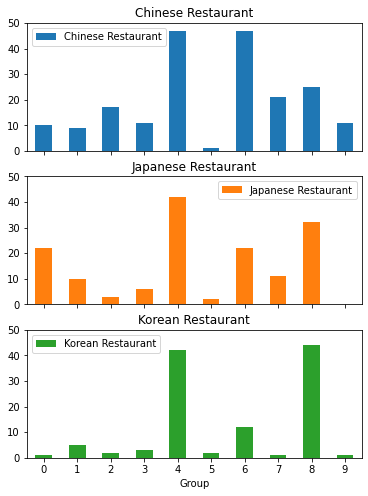

In [42]:
df = df_toronto_groups[['Group', 'Chinese Restaurant', 'Japanese Restaurant', 'Korean Restaurant']]
df.plot(x = 'Group', kind = 'bar', rot = 0, ylim = (0, 50), subplots = True, figsize = (6, 8))

We can see that the top three groups having most number of restaurants of the three categories are in Group 4, 6 and 8 of neighborhoods, where more than 40 restaurants in Group 4 of each category exist. 
Here let's define the competition strength  as below:

Competition strength | Number of Restaurants
-------------------- | ---------------------
Strong | > 20
Medium | (5, 20]
Low    | <= 5

For Chinese restaurants, the competition is only low in Group 5. On the other hand, Group 2, 5, and 9 do not have many Japanese restaurants. And Korean restaurants do not have strong competitions in most groups except Group 4, 6 and 8. 

If we consider all Chinese, Japanese and Korean restaurants as a whole as **"East Asian Restaurant"**, we will define the competition strength is low when the number of restaurants is no more than 15. We will see that only Group 5 and 9 are not quite crowded with East Asian Restaurants. 

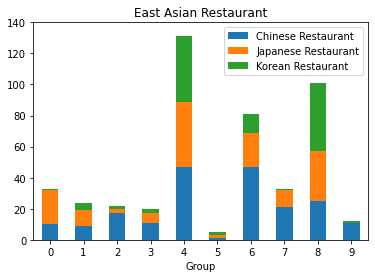

In [45]:
df.plot(x = 'Group', kind = 'bar', rot = 0, ylim = (0, 140), stacked = True, title = 'East Asian Restaurant')

## Conclusion <a name="conclusion"></a>

To sum up, we have used K-means to make 10 groups of neighborhoods from 103 regions of Toronto. And then we explored the number of Korean, Japanese, and Chinese restaurants within the 4000 meters radius of each center of those 10 groups, and learned the distribution of the restaurants. We assumed there is a relation between number of restaurants and competition strength. We determined that Group 5 is weak in competition for Chinese restaurants, while Japanese restaurant density is low in Group 2, 5 and 9. Korean restaurants only have strong competitions in Group 4, 6, and 8. We also treated them as a whole of East Asian Restaurants and found that there are not many of them in Group 5 and 9. Hence, we have identified the candidates of neighborhoods that are suitable to open a new Chinese, Japanese, Korean restaurants. The stakeholders can further investigate those neighborhoods to determine the final location to launch the new restaurant.